In [171]:
import numpy as np
import torch
import sys
sys.path.insert(1, '/home/suarez08/PhD_PINNs/PIPS_framework')
from sobolev import Sobolev
from sobolev import Sobolev
from solver import Solver
from utils import matmul
import surrogates
import time
sys.path.insert(1, '/home/suarez08/minterpy/src')
import minterpy as mp
from diffeomorphisms import hyper_rect
import matplotlib
import matplotlib.pyplot as plt
#style.use('dark_background')
matplotlib.rcdefaults() 

In [172]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

Parameters required for interpolation

In [173]:
deg_quad = 30
rect = rect = np.array([[-1.0, 1.0], [-1.0, 1.0]])
print(rect.shape)
diffeo_param = hyper_rect(*rect)
print('diffeo_param',diffeo_param)
sob_param = Sobolev(deg=deg_quad, dim=2)
print('sob_param',sob_param)

##### Sobolev norm for the inteprolation
sob_param.set_s(0)
#####
x_plt, _, _, x, _, _ = sob_param.get_quad()
metric_param = sob_param.metric()
W_param = sob_param.get_leja_weights()
u_ob = surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
metric_2d = sob_param.metric(weak=True)
x_l = sob_param.get_xs()
X_p = u_ob.data_axes([x,x]).T

(2, 2)
diffeo_param (<function hyper_rect.<locals>.<lambda> at 0x7f9de1b1a790>, <function hyper_rect.<locals>.<lambda> at 0x7f9db93c20d0>)
sob_param <sobolev.Sobolev object at 0x7f9de05957c0>


Function to be interpolated

gt -> Ground truth as a function

Fr -> Evaluation of gt at the grid x

In [162]:
wx= 10
wy= 10
x = torch.tensor(x)
X, Y = torch.meshgrid(x,x)
Fr = (torch.sin(wx*X)*torch.cos(wy*Y)).reshape(-1)

print('Fr.shape',Fr.shape)
gt = lambda x, y: np.sin(wx*x)*np.cos(wy*y)
x.shape

Fr.shape torch.Size([961])


torch.Size([31])

In [179]:
X, Y

array([-0.99708748,  0.99708748,  0.        ,  0.56324916, -0.64270672,
        0.83992032, -0.83992032, -0.29471807,  0.29471807,  0.930757  ,
       -0.930757  , -0.47819378,  0.71577678,  0.09955531, -0.96250393,
        0.96250393, -0.1981212 ,  0.47819378, -0.71577678,  0.78173315,
       -0.88976003,  0.1981212 ,  0.98468591, -0.56324916, -0.98468591,
        0.64270672, -0.09955531,  0.88976003, -0.78173315,  0.3883859 ,
       -0.3883859 ])

In [174]:
#experiments
import nibabel as nib
image_path = '/media/chethan/New Volume/Thesis/mri_learning/mri_dwi_dataset/OASIS3/OAS30063/OAS30063_MR_d0160/dwi1/NIFTI/sub-OAS30063_ses-d0160_dwi.nii.gz'

image_obj = nib.load(image_path)

image_data = image_obj.get_fdata()
image_data = image_data[:,:,30,0]
image_data.shape

Fr = image_data
Fr[np.where(Fr < 0)] = 0
Fr = Fr.reshape(Fr.shape[0]*Fr.shape[1])

Fr = torch.tensor(Fr)
len(Fr)

9216

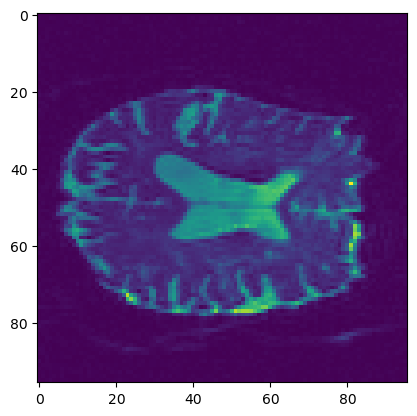

In [175]:
plt.imshow(Fr.reshape(96,96))

Solve the analytic gradient flow, the trained model is u_ob

In [165]:
start = time.time()
K = torch.eye(len(X_p))
KsK = matmul(X_p.T, metric_2d(matmul(torch.diag(W_param),X_p)))
Ksf = matmul(X_p.T, metric_2d(matmul(torch.diag(W_param),Fr)))
w = matmul(KsK.inverse(), Ksf)
u_ob.set_weights(w)
end = time.time()
print('time consumption: %.2fs' % (end-start))

time consumption: 0.17s


Validation

In [166]:
b = np.linspace(-1,1,100)#np.array([x[0]])#np.linspace(-1,1,100)
xf= np.linspace(-1,1,100)#x#np.linspace(-1,1,100)
BF, XF = np.meshgrid(b,xf)
X_test = u_ob.data_axes([b,xf]).T
print('X_test.shape',X_test.shape)
X_final = u_ob.data_axes([x,x]).T
pred = u_ob(X_test).T[0].reshape(len(b),len(xf)).detach().numpy()
GT = Fr.reshape(len(x),len(x))

X_test.shape torch.Size([10000, 961])


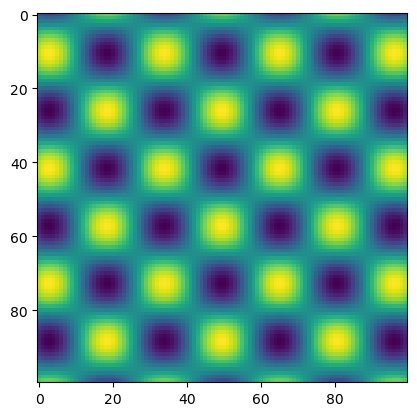

In [167]:
plt.imshow(pred.reshape(100,100))

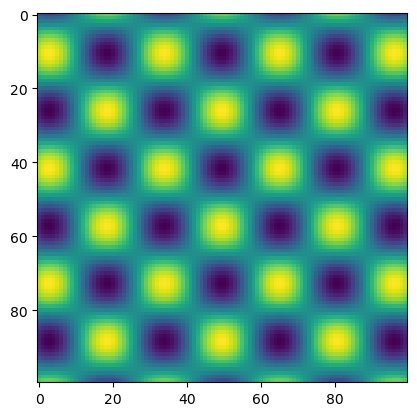

In [177]:
plt.imshow(gt(XF, BF))

In [169]:
np.max(abs(u_ob(X_test).T[0].detach().numpy()-gt(XF.reshape(-1), BF.reshape(-1))))

1.155561202281774e-10

In [170]:
np.mean(abs(u_ob(X_test).T[0].detach().numpy()-gt(XF.reshape(-1), BF.reshape(-1))))

3.585852890986528e-13